In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate

In [3]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
casp_protein_id = 'T1030'   # 6ya2
winsizes = [4,5,6,7]
casp_protein_ids = ['T1024', 'T1096', 'T1027', 'T1058', 'T1096', 'T1030']
# ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']:

das = []
xray_phi_psi = []
for casp_protein_id in casp_protein_ids:
    da = DihedralAdherence(casp_protein_id, winsizes, PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128])
    da.load_results_da()
    das.append(da)
    xray_phi_psi.append(da.xray_phi_psi)
xray_phi_psi = pd.concat(xray_phi_psi)

Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


In [18]:
lengths = [15000, 5000, 400, 200]
datas = {}
n_matches = []
for da in das:
    n_matches.append([da.casp_protein_id])
    for q,l in zip(da.queries, lengths):
        df = q.results
        df = df.reset_index()
        df['count'] = df.groupby('seq').cumcount()
        phi = df.pivot(index='seq', columns='count', values='phi')
        psi = df.pivot(index='seq', columns='count', values='psi')
        n_matchesi = phi.shape[1]
        n_matches[-1].append(n_matchesi)
        if n_matchesi < l:
            phi = pd.concat([
                phi,
                pd.DataFrame(np.zeros((phi.shape[0], l-phi.shape[1])), columns=range(phi.shape[1], l), index=phi.index)
            ], axis=1)
            psi = pd.concat([
                psi,
                pd.DataFrame(np.zeros((psi.shape[0], l-psi.shape[1])), columns=range(psi.shape[1], l), index=psi.index)
            ], axis=1)
        else:
            phi = phi.iloc[:, :l]
            psi = psi.iloc[:, :l]
        df = pd.merge(phi, psi, left_index=True, right_index=True, suffixes=('_phi', '_psi'))
        print(q.winsize, n_matchesi, phi.shape, psi.shape, df.shape)
        if not q.winsize in datas:
            datas[q.winsize] = [df]
        else:
            datas[q.winsize].append(df)
print(tabulate(n_matches, headers=winsizes, tablefmt='simple_grid'))
for k,v in datas.items():
    datas[k] = pd.concat(v).fillna(0)
    print(k, datas[k].shape)

4 15656 (403, 15000) (403, 15000) (403, 30000)
5 1136 (387, 5000) (387, 5000) (387, 10000)
6 335 (176, 400) (176, 400) (176, 800)
7 200 (21, 200) (21, 200) (21, 400)
4 8982 (459, 15000) (459, 15000) (459, 30000)
5 5336 (460, 5000) (460, 5000) (460, 10000)
6 350 (458, 400) (458, 400) (458, 800)
7 155 (457, 200) (457, 200) (457, 400)
4 9926 (171, 15000) (171, 15000) (171, 30000)
5 1109 (154, 5000) (154, 5000) (154, 10000)
6 237 (55, 400) (55, 400) (55, 800)
7 192 (6, 200) (6, 200) (6, 400)
4 14035 (376, 15000) (376, 15000) (376, 30000)
5 2334 (355, 5000) (355, 5000) (355, 10000)
6 228 (151, 400) (151, 400) (151, 800)
7 188 (24, 200) (24, 200) (24, 400)
4 8982 (459, 15000) (459, 15000) (459, 30000)
5 5336 (460, 5000) (460, 5000) (460, 10000)
6 350 (458, 400) (458, 400) (458, 800)
7 155 (457, 200) (457, 200) (457, 400)
4 15757 (269, 15000) (269, 15000) (269, 30000)
5 3989 (268, 5000) (268, 5000) (268, 10000)
6 1723 (134, 400) (134, 400) (134, 800)
7 55 (13, 200) (13, 200) (13, 400)
┌──────

In [19]:
all_X = []
all_y = []
seqs = xray_phi_psi['seq_ctxt'].unique()
for seq in seqs:
    yi = xray_phi_psi[xray_phi_psi['seq_ctxt']==seq][['phi', 'psi']].values[0]
    if np.isnan(yi).any():
        continue
    Xi = []
    for q,l in zip(da.queries, lengths):
        s = q.get_subseq(seq)
        if s in datas[q.winsize].index:
            Xi.append(datas[q.winsize].loc[s].values)
            if Xi[-1].ndim > 1:
                Xi[-1] = Xi[-1][0]
        else:
            Xi.append(np.zeros((l*2)))
    Xi = np.concatenate(Xi)
    if max(Xi) == 0: # no matches
        continue
    all_X.append(Xi)
    all_y.append(yi)
all_X = np.stack(all_X)
all_y = np.stack(all_y)
print(all_X.shape, all_y.shape)

(1382, 41200) (1382, 2)


In [20]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([1105, 41200]) torch.Size([1105, 2]) torch.Size([277, 41200]) torch.Size([277, 2])


In [33]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train.numpy(),y_train.numpy())


In [21]:
length = sum([l*2 for l in lengths])
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(length, 2)
        # self.fc2 = nn.Linear(2, 2)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x
model = Net().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [22]:
X,y = next(iter(trainloader))

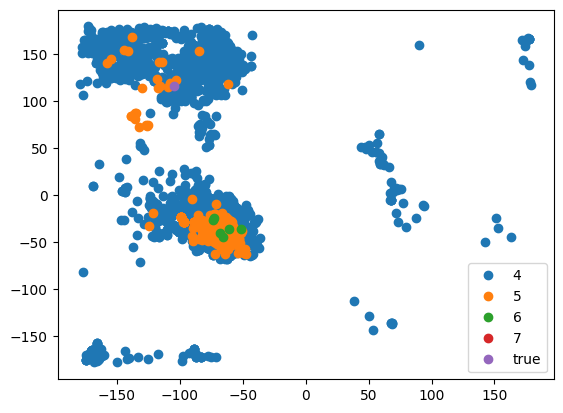

In [23]:
def plot(Xp, y, i, logits=None):
    ls = lengths
    Xp = Xp.cpu().clone().detach()
    y = y.cpu().clone().detach()
    Xp[Xp==0] = np.nan
    s = [sum(lengths[:i]*2) for i,l in enumerate(ls)]
    plt.plot(Xp[i,s[0]:s[0]+ls[0]].detach(),Xp[i,s[0]+ls[0]:s[0]+ls[0]*2].detach(), 'o', label='4')
    plt.plot(Xp[i,s[1]:s[1]+ls[1]].detach(),Xp[i,s[1]+ls[1]:s[1]+ls[1]*2].detach(), 'o', label='5')
    plt.plot(Xp[i,s[2]:s[2]+ls[2]].detach(),Xp[i,s[2]+ls[2]:s[2]+ls[2]*2].detach(), 'o', label='6')
    plt.plot(Xp[i,s[3]:s[3]+ls[3]].detach(),Xp[i,s[3]+ls[3]:s[3]+ls[3]*2].detach(), 'o', label='7')
    plt.plot(y[i,0].detach(),y[i,1].detach(), 'o', label='true')
    if logits is not None:
        logits = logits.cpu().clone().detach()
        plt.plot(logits[i,0].detach(),logits[i,1].detach(), 'o', label='pred')
    plt.legend()
plot(X,y,1)

In [24]:
train_losses = []
test_losses = []
for epoch in (pbar := tqdm(range(500))):
    losses = []
    model.train()
    for X,y in trainloader:
        X,y = X.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,y in testloader:
        with torch.no_grad():
            X,y = X.to('cuda'), y.to('cuda')
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})

100%|██████████| 500/500 [00:40<00:00, 12.27it/s, train_loss=441, test_loss=8.33e+3]    


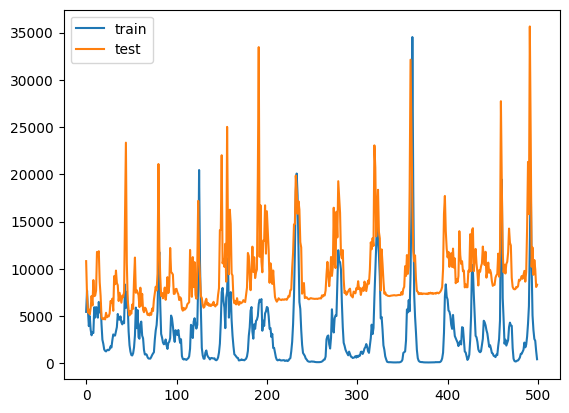

In [25]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

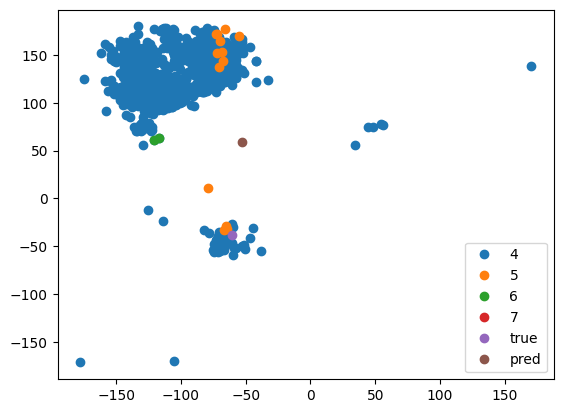

In [28]:
for X,y in testloader:
    with torch.no_grad():
        X,y = X.to('cuda'), y.to('cuda')
        logits = model(X)
    break
plot(X, y, 0, logits)